# -----: Importing necessary libraries -----

In [1]:
import praw
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Scraping Data from Reddit ---

In [2]:
reddit = praw.Reddit(
    client_id="fjoMsFpdDUwNznfbHI_Phw",
    client_secret="8YPEzjT7MKo0OUYcIqHuSG0RZmNsng",
    user_agent="StockMovementPredictor/0.1"
)

posts = []
subreddit = reddit.subreddit('stocks')
for post in subreddit.hot(limit=5000):  # Adjust limit as needed
    posts.append({
        'title': post.title,
        'author': post.author.name if post.author else None,
        'score': post.score,
        'num_comments': post.num_comments,
        'created': post.created_utc
    })

df = pd.DataFrame(posts)

# --- Step 2: Data Preprocessing ---

In [3]:
# Convert 'created' to datetime
df['created'] = pd.to_datetime(df['created'], unit='s')

# Extract day of the week and time of day
df['day_of_week'] = df['created'].dt.dayofweek  # 0=Monday, 6=Sunday
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['time_of_day'] = df['created'].dt.hour

# Calculate comment-to-score ratio
df['comment_to_score_ratio'] = np.where(df['score'] > 0, df['num_comments'] / df['score'], 0)

# --- Step 3: Sentiment Analysis using VADER ---

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each title and calculate sentiment scores
df['sentiment_score'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['positive_sentiment'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
df['negative_sentiment'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
df['neutral_sentiment'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['neu'])

# Check if required columns are present before calculating weighted_sentiment
if 'positive_sentiment' in df.columns and 'negative_sentiment' in df.columns:
    df['weighted_sentiment'] = (df['positive_sentiment'] - df['negative_sentiment']) * df['score']
else:
    print("Required columns for 'weighted_sentiment' calculation are missing.")

# Create a composite sentiment score
df['sentiment_composite'] = df['sentiment_score'] + df['weighted_sentiment']

# Generate target variable (stock_movement) - Example
df['stock_movement'] = (df['score'] + df['num_comments'] * 0.5 + df['sentiment_score'] * 100).apply(round)

# Drop unnecessary columns
df = df.drop(['positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 'is_weekend', 'comment_to_score_ratio'], axis=1)

# Drop rows with missing data
df.dropna(inplace=True)


# --- Step 4: Exploratory Data Analysis (EDA) ---

In [5]:
## First few rows of the Data
df.head()

,title,author,score,num_comments,created,day_of_week,time_of_day,sentiment_score,weighted_sentiment,sentiment_composite,stock_movement
0,r/Stocks Daily Discussion & Fundamentals Frida...,AutoModerator,25,477,2024-11-15 10:30:09,4,10,0.0000,0.000,0.0000,264
1,r/Stocks Daily Discussion & Fundamentals Frida...,AutoModerator,10,167,2024-11-29 10:30:09,4,10,0.0000,0.000,0.0000,94
2,23-Hour Party People: U.S. stocks may soon tra...,DecisionNo1902,315,140,2024-11-29 18:01:21,4,18,0.4019,62.055,62.4569,425
3,Thoughts on buying BRB.K this month instead of...,Life-Ambition1432,34,48,2024-11-29 14:54:01,4,14,0.0000,0.000,0.0000,58
4,Fellow Canadians: What’s the Difference Betwee...,stanxv,4,3,2024-11-29 21:40:27,4,21,0.0000,0.000,0.0000,6


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175 entries, 0 to 175
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                175 non-null    object        
 1   author               175 non-null    object        
 2   score                175 non-null    int64         
 3   num_comments         175 non-null    int64         
 4   created              175 non-null    datetime64[ns]
 5   day_of_week          175 non-null    int32         
 6   time_of_day          175 non-null    int32         
 7   sentiment_score      175 non-null    float64       
 8   weighted_sentiment   175 non-null    float64       
 9   sentiment_composite  175 non-null    float64       
 10  stock_movement       175 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int32(2), int64(3), object(2)
memory usage: 15.0+ KB


In [7]:
## Summary Statistics of the Data
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
             score  num_comments                     created  day_of_week  \
count   175.000000    175.000000                         175   175.000000   
mean    112.337143     97.211429  2024-11-21 16:40:38.960000     2.771429   
min       0.000000      0.000000         2024-11-13 21:52:30     0.000000   
25%       9.000000     13.500000  2024-11-18 15:14:05.500000     1.000000   
50%      33.000000     44.000000         2024-11-21 14:45:36     3.000000   
75%     133.000000    109.500000  2024-11-25 16:25:10.500000     4.000000   
max    1431.000000   2265.000000         2024-11-30 04:07:50     6.000000   
std     194.262607    196.832287                         NaN     1.743390   

       time_of_day  sentiment_score  weighted_sentiment  sentiment_composite  \
count   175.000000       175.000000          175.000000           175.000000   
mean     13.994286         0.067223            6.925817             6.993040   
min       0.000000        -0.718400         -1

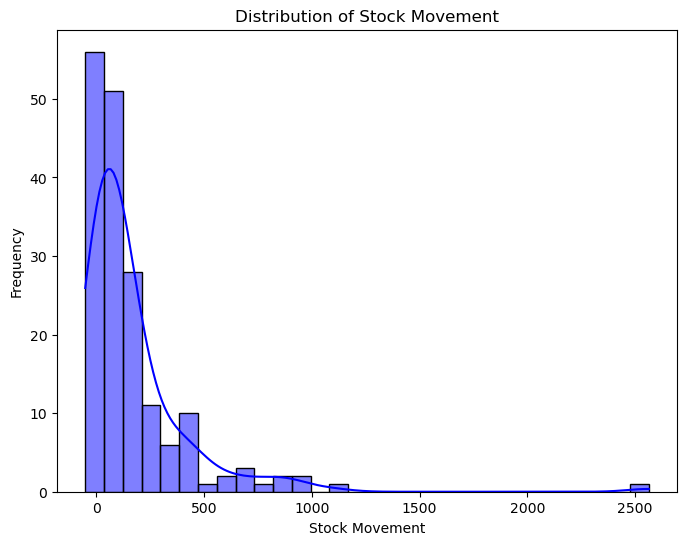

In [8]:
## Visualize Distribution of Stock Movement (Target Variable)
plt.figure(figsize=(8, 6))
sns.histplot(df['stock_movement'], kde=True, bins=30, color='blue')
plt.title('Distribution of Stock Movement')
plt.xlabel('Stock Movement')
plt.ylabel('Frequency')
plt.show()

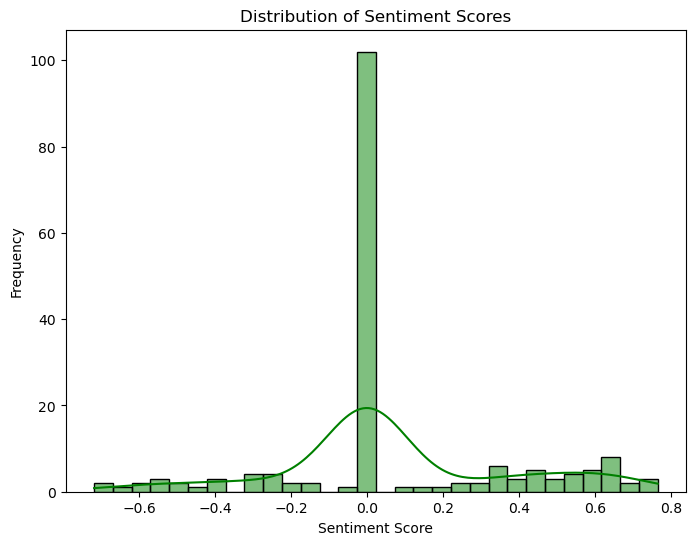

In [9]:
## Visualize Distribution of Sentiment Scores
plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment_score'], kde=True, bins=30, color='green')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

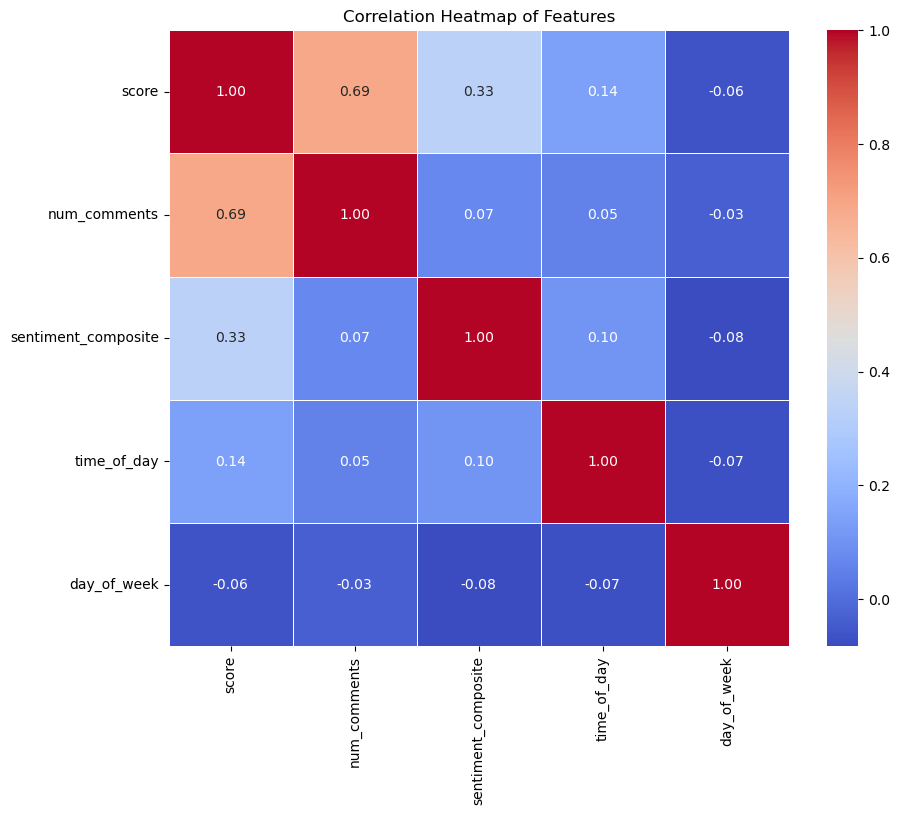

In [10]:
correlation_matrix = df[['score', 'num_comments', 'sentiment_composite',  'time_of_day', 'day_of_week']].corr()

# Set up the figure size
plt.figure(figsize=(10, 8))
# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# Title for the heatmap
plt.title('Correlation Heatmap of Features')
# Display the plot
plt.show()

In [11]:
correlation_matrix

,score,num_comments,sentiment_composite,time_of_day,day_of_week
score,1.000000,0.689927,0.332001,0.139103,-0.063983
num_comments,0.689927,1.000000,0.072161,0.054079,-0.033321
sentiment_composite,0.332001,0.072161,1.000000,0.104695,-0.082890
time_of_day,0.139103,0.054079,0.104695,1.000000,-0.073681
day_of_week,-0.063983,-0.033321,-0.082890,-0.073681,1.000000


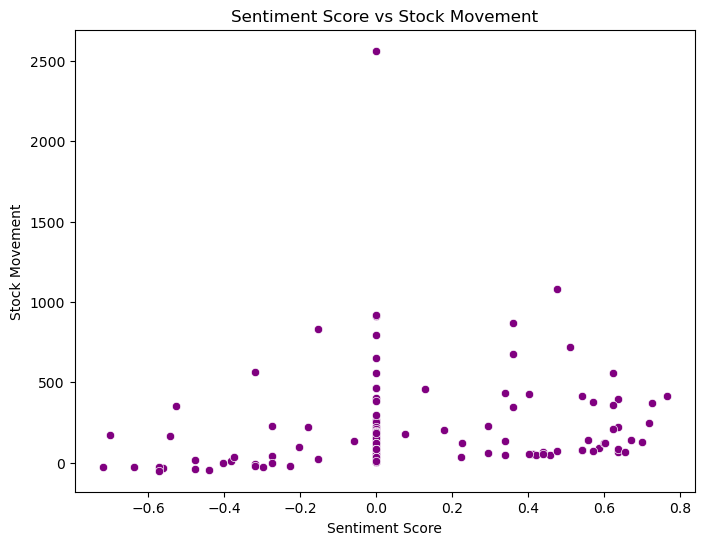

In [12]:
## Visualizing Sentiment vs Stock Movement
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sentiment_score', y='stock_movement', data=df, color='purple')
plt.title('Sentiment Score vs Stock Movement')
plt.xlabel('Sentiment Score')
plt.ylabel('Stock Movement')
plt.show()

C:\Users\Nasreen RPX\AppData\Local\Temp\ipykernel_17912\749197018.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.index, y=top_features.values, palette='viridis')


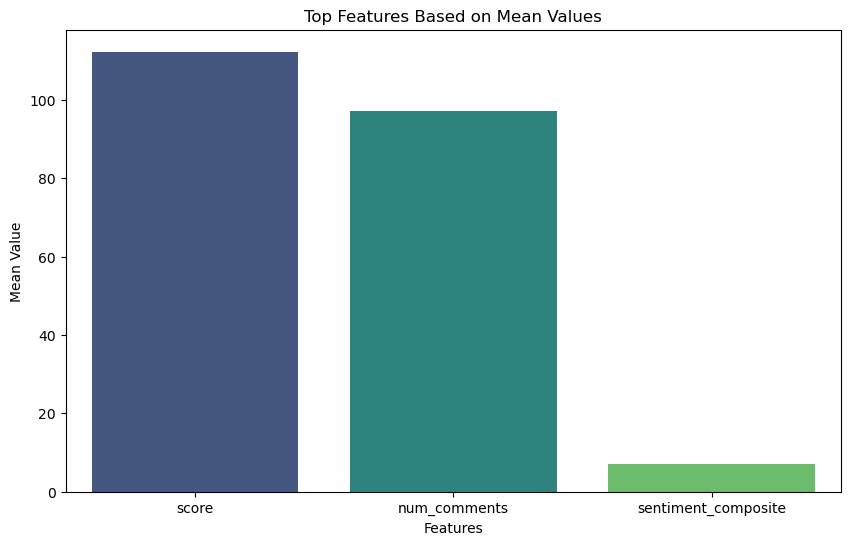

In [23]:
# Updated top features to include only relevant columns
top_features = df[['score', 'num_comments', 'sentiment_composite']].mean()
top_features = top_features.sort_values(ascending=False)

# Plot the mean values of top features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.index, y=top_features.values, palette='viridis')
plt.title('Top Features Based on Mean Values')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.show()


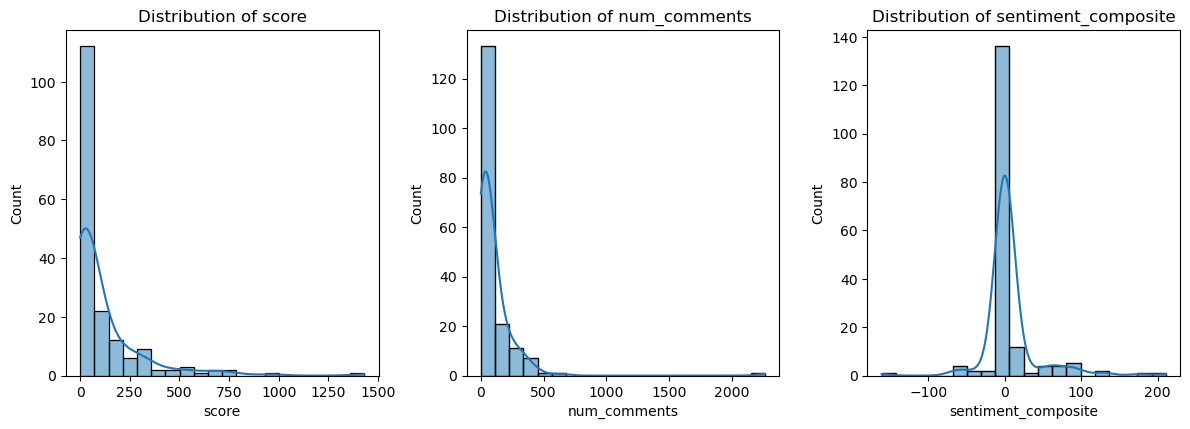

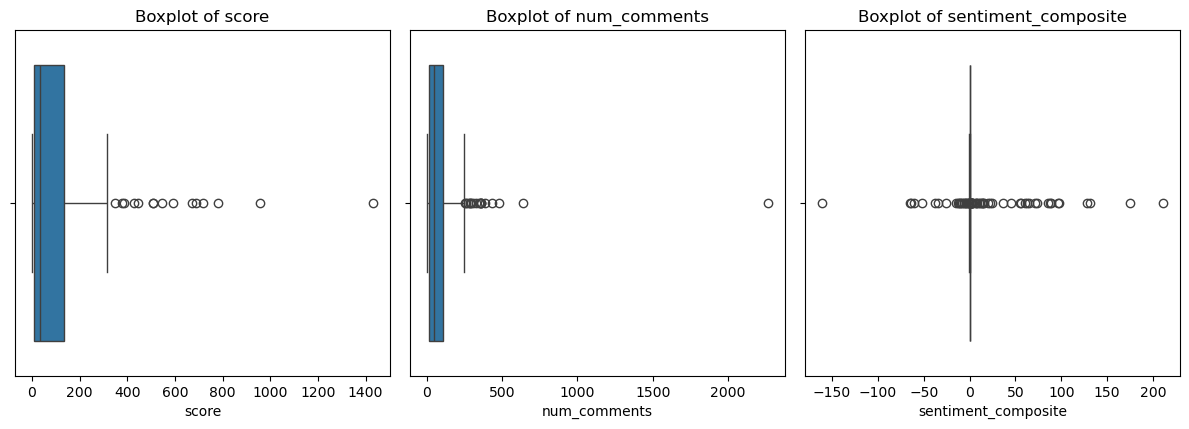

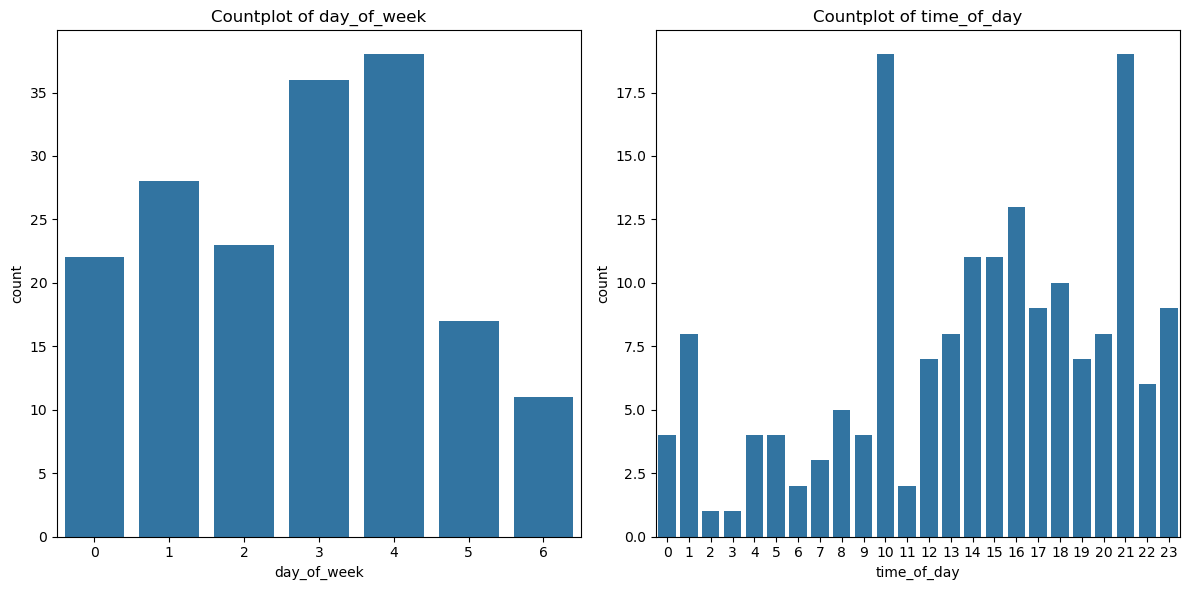

In [29]:
# Univariate Analysis for Numerical Features
numerical_features = ['score', 'num_comments', 'sentiment_composite']

# Plot histograms for each numerical feature
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns
    sns.histplot(df[feature], kde=True, bins=20)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
plt.show()

# Boxplots for numerical features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()
plt.show()

# Univariate Analysis for Categorical Features (Example: day_of_week, time_of_day)
categorical_features = ['day_of_week', 'time_of_day']

plt.figure(figsize=(12, 6))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 2, i)  # 1 row, 2 columns
    sns.countplot(x=df[feature])
    plt.title(f'Countplot of {feature}')
    plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

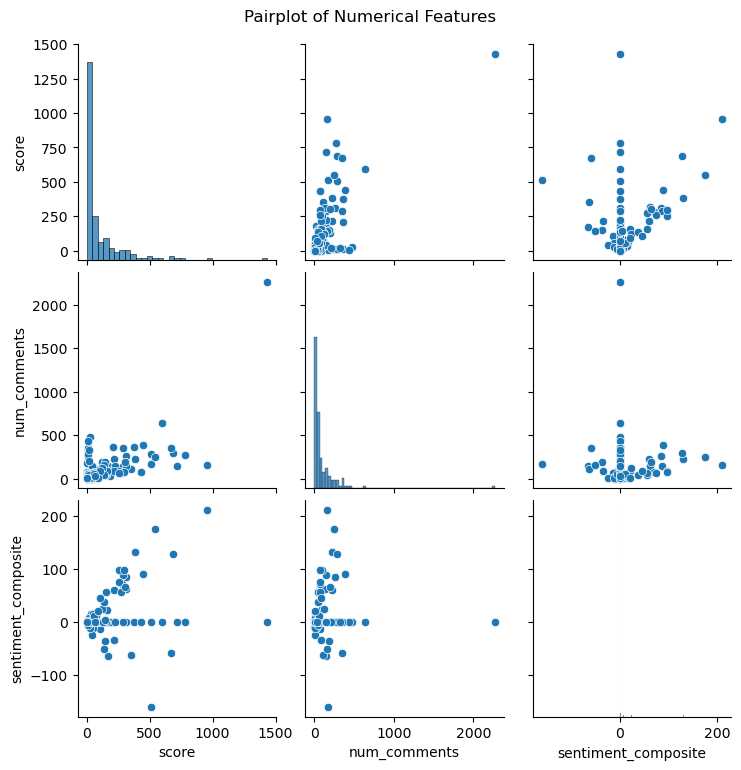

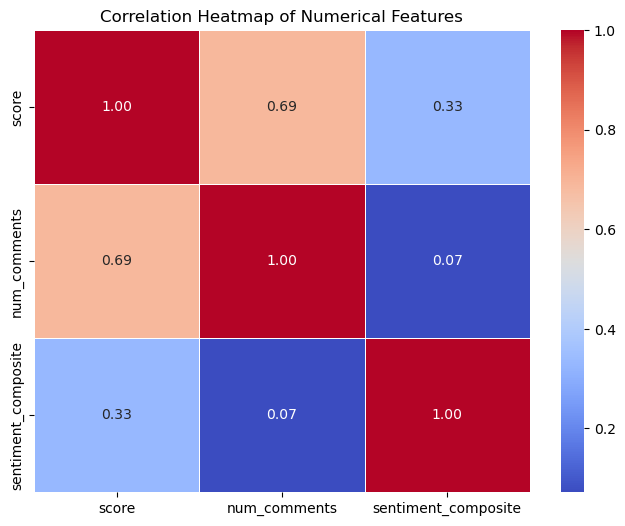

In [30]:
 #Bivariate Analysis: Numerical vs. Numerical Analysis
# Scatterplot for numerical features
plt.figure(figsize=(10, 8))
sns.pairplot(df[['score', 'num_comments', 'sentiment_composite']])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

# Correlation heatmap for numerical features
correlation_matrix = df[['score', 'num_comments', 'sentiment_composite']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


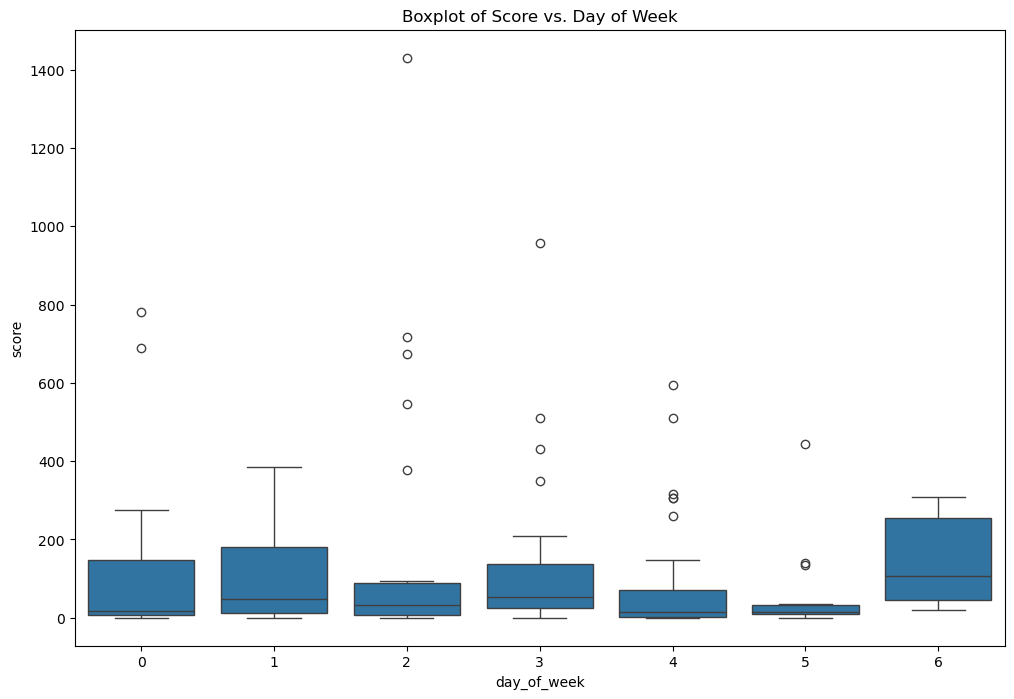

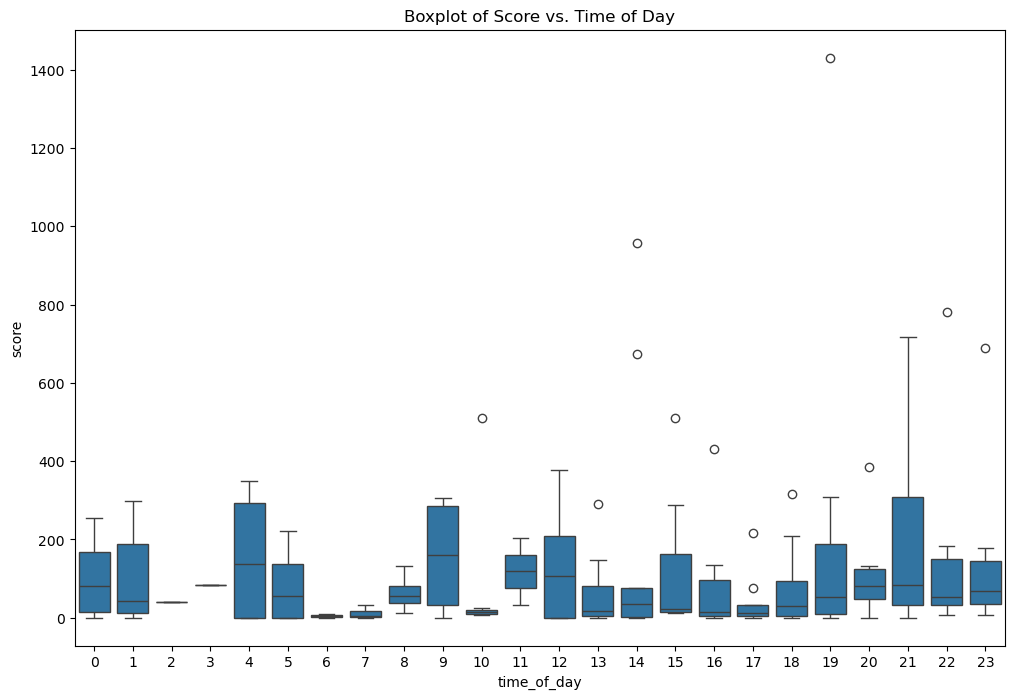

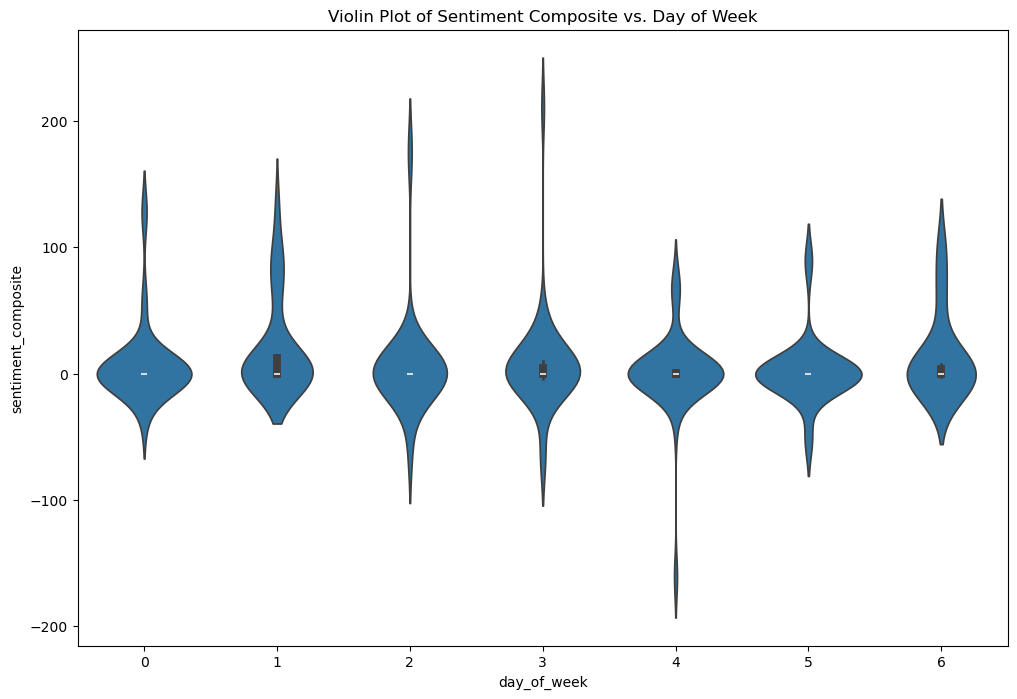

In [32]:
# Bivariate Analysis: categorical vs. Numerical Analysis
# Boxplots for categorical vs. numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(x='day_of_week', y='score', data=df)
plt.title('Boxplot of Score vs. Day of Week')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='time_of_day', y='score', data=df)
plt.title('Boxplot of Score vs. Time of Day')
plt.show()

# Violin plots (Alternative to boxplots)
plt.figure(figsize=(12, 8))
sns.violinplot(x='day_of_week', y='sentiment_composite', data=df)
plt.title('Violin Plot of Sentiment Composite vs. Day of Week')
plt.show()


# --- Step 5: Feature and Target Selection ---

In [14]:
# Columns to drop
columns_to_drop = ['sentiment_score']

# Drop unnecessary columns
df = df.drop(columns=columns_to_drop)

# Updated feature set
features = ['score', 'num_comments', 'sentiment_composite',  'time_of_day', 'day_of_week']
X = df[features]
y = df['stock_movement']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# --- Step 6: Model Building with XGBoost ---

In [15]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],  # Number of boosting rounds
    'max_depth': [3],            # Maximum depth of the trees
    'learning_rate': [0.01], # Step size shrinking
    'min_child_weight': [1, 3, 5],      # Minimum sum of instance weight
    'subsample': [0.5, 0.7, 1.0],       # Fraction of samples used for training
    'colsample_bytree': [0.7, 0.8, 1.0],# Fraction of features used for each tree
}
# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7}


# --- Step 7: Model Evaluation ---

In [16]:
y_pred = best_xgb_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)*100

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

Mean Absolute Error (MAE): 29.64569443975176
Root Mean Squared Error (RMSE): 39.94187664320239
R² Score: 97.17267811471272


C:\Users\Nasreen RPX\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



# --- Step 8: Visualizations of Model Evaluation ---

C:\Users\Nasreen RPX\AppData\Local\Temp\ipykernel_17912\4139796530.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


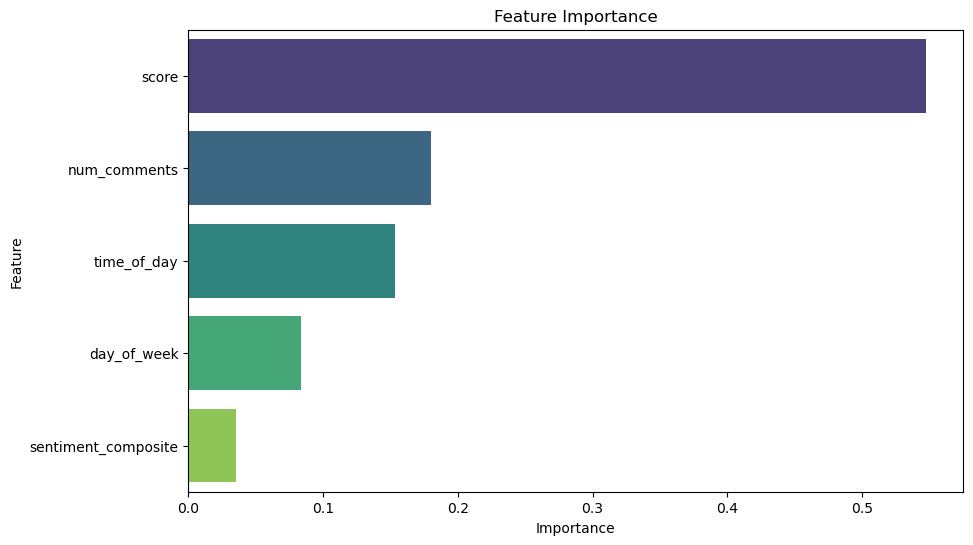

In [17]:
# Feature importance visualization
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

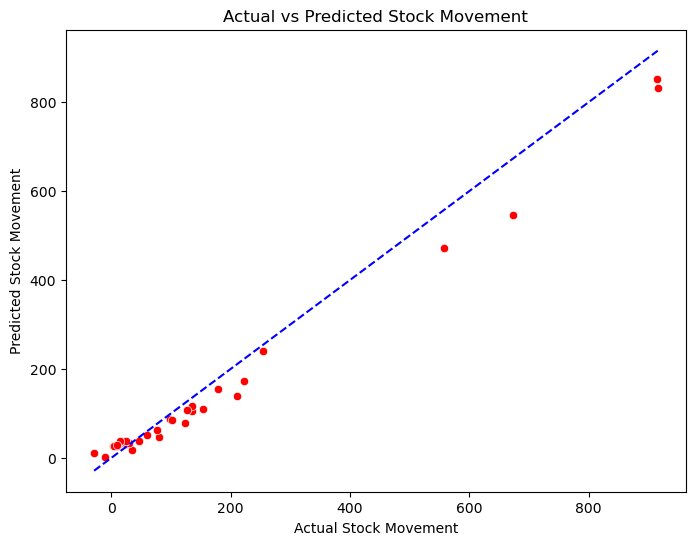

In [18]:
# Actual vs Predicted Stock Movement
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='blue')
plt.title('Actual vs Predicted Stock Movement')
plt.xlabel('Actual Stock Movement')
plt.ylabel('Predicted Stock Movement')
plt.show()

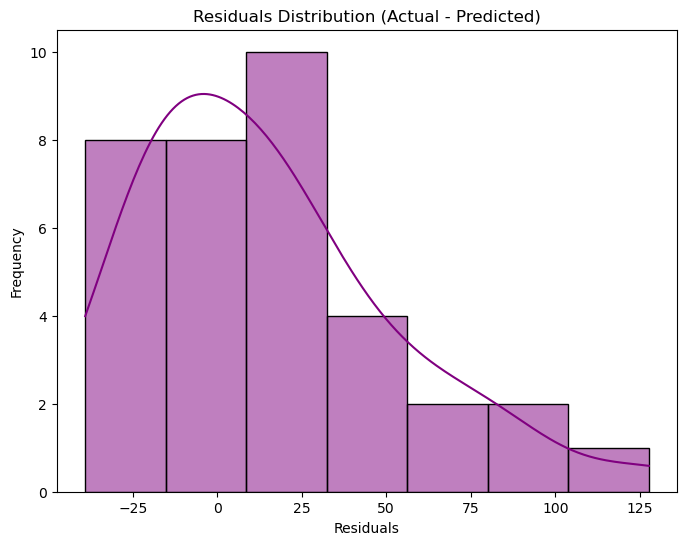

In [19]:
# Residuals Plot (difference between actual and predicted values)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution (Actual - Predicted)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

C:\Users\Nasreen RPX\AppData\Local\Temp\ipykernel_17912\1452396013.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='Blues_d')


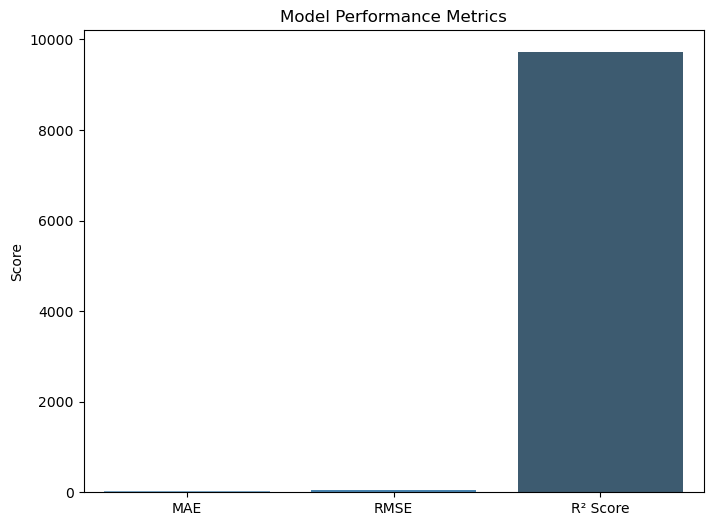

In [20]:
# Convert to percentage
r2_percent = r2 * 100

# Bar plot for model performance metrics
metrics = {'MAE': mae, 'RMSE': rmse, 'R² Score': r2_percent}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='Blues_d')
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()

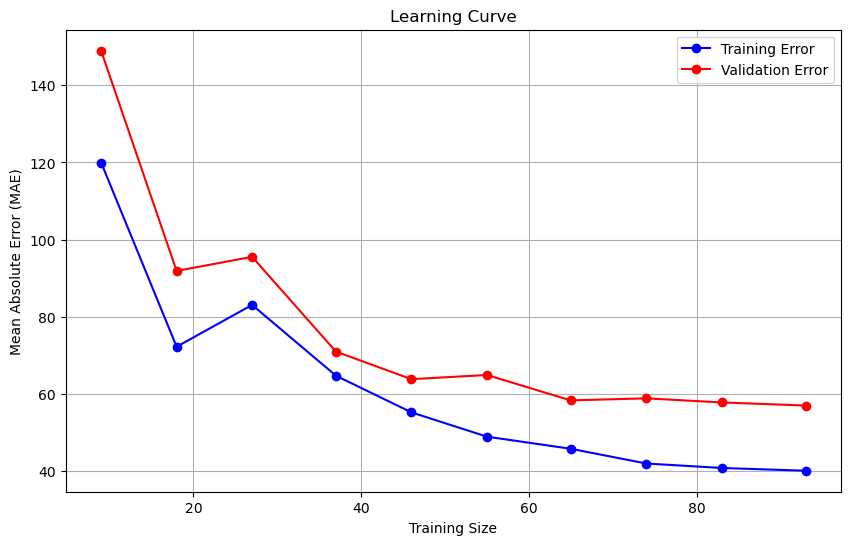

In [21]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Calculate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_xgb_model, 
    X=X_train, 
    y=y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),  # Train with 10% to 100% of the data
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',  # Use MAE as scoring metric
    n_jobs=-1  # Use all available cores for computation
)

# Calculate mean and standard deviation of train and validation scores
train_mean = -train_scores.mean(axis=1)  # We negate to convert negative MAE to positive
val_mean = -val_scores.mean(axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Error', color='blue', marker='o')
plt.plot(train_sizes, val_mean, label='Validation Error', color='red', marker='o')

# Plot formatting
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


Cross-validation scores (Negative MAE): [-136.70947937  -43.36670135  -26.23416214  -41.87645403  -26.95783133]
Average Cross-validation MAE: 55.02892564364843


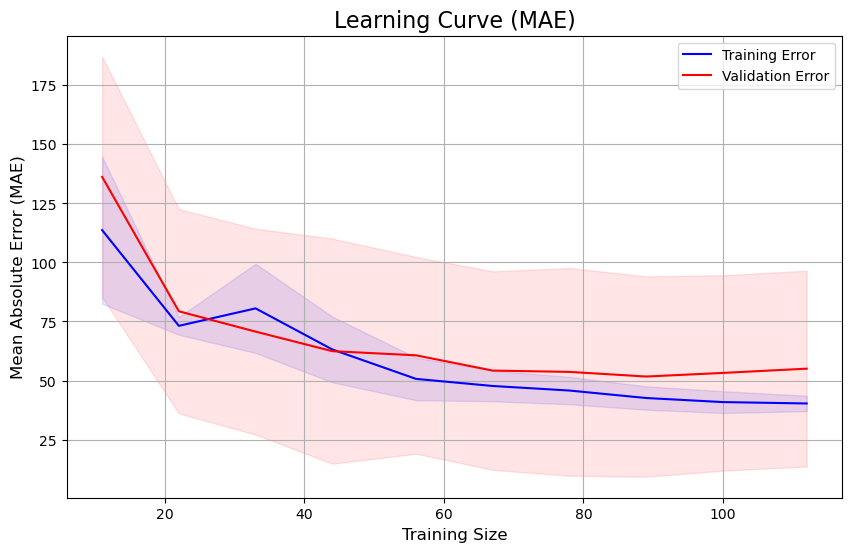

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Perform Cross-validation
cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Print the mean cross-validation score
print(f"Cross-validation scores (Negative MAE): {cv_scores}")
print(f"Average Cross-validation MAE: {-cv_scores.mean()}")

# Learning Curve Analysis
train_sizes, train_scores, validation_scores = learning_curve(
    best_xgb_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Mean and Standard Deviation for training and validation
train_mean = -train_scores.mean(axis=1)
validation_mean = -validation_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
validation_std = validation_scores.std(axis=1)

# Plotting the Learning Curve
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training Error", color="blue")
plt.plot(train_sizes, validation_mean, label="Validation Error", color="red")

# Filling the area between the curves for standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color="red")

plt.title("Learning Curve (MAE)", fontsize=16)
plt.xlabel("Training Size", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
